In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import FeatureUnion

from IPython.display import display

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [37]:
# Loading the data
train = pd.read_csv('data/titanic-train.csv', index_col='PassengerId')
test = pd.read_csv('data/titanic-test.csv', index_col='PassengerId')

full_data = [train, test]

# Lets have a look at the data
train.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Getting to know the data

In [38]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Some of the **age** rows are empty, we weould need to **implant** some data there.

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [40]:
for data in full_data:
    print(data.isnull().sum().sort_values())

Survived      0
Pclass        0
Name          0
Sex           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
Age         177
Cabin       687
dtype: int64
Pclass        0
Name          0
Sex           0
SibSp         0
Parch         0
Ticket        0
Embarked      0
Fare          1
Age          86
Cabin       327
dtype: int64


Трябва да попълним липсващите данни, но преди това...

## Базови модели

In [41]:
X = train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
y = train['Survived']

X['Age'].fillna(X['Age'].mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8, stratify=y)

In [42]:
lr_model = LogisticRegression().fit(X_train, y_train)
rf_model = RandomForestClassifier().fit(X_train, y_train)
svc_model = SVC(C=1).fit(X_train, y_train)

print("logistic recression train score:", lr_model.score(X_train, y_train))
print("logistic recression test score: ", lr_model.score(X_test, y_test), end='\n\n')

print("random forest train score:", rf_model.score(X_train, y_train))
print("random forest recression test score: ", rf_model.score(X_test, y_test), end='\n\n')

print("support vector classifier score:", svc_model.score(X_train, y_train))
print("support vector classifier score: ", svc_model.score(X_test, y_test), end='\n\n')

logistic recression train score: 0.693113772455
logistic recression test score:  0.744394618834

random forest train score: 0.923652694611
random forest recression test score:  0.686098654709

support vector classifier score: 0.862275449102
support vector classifier score:  0.659192825112



Доста овърфит при svm и random forest класификаторите.

# Малко помощни класове

Този клас ще one-hot-encode-ва стрингови (категорийни) фийчъри. Подходящ е за pipeline-ове.

In [45]:
class StringLabelBinerizer(LabelBinarizer):
    def __init__(self, prefix='col', key=lambda x: x, **kwargs):
        self.prefix = prefix
        self.key = key
        super(StringLabelBinerizer, self).__init__(**kwargs)
    
    def map_input(self, y):
        return y

    def fit(self, y, prefix='col', key=lambda x: x):
        self.key = key
        return super(StringLabelBinerizer, self).fit(self.map_input(y))

    def transform(self, y):
        cols = list(map(lambda s: self.prefix + '_' + s, self.classes_))
        if len(cols) == 2:
            cols = [self.prefix]
        result = pd.DataFrame(super(StringLabelBinerizer, self).transform(self.map_input(y)), columns=cols)
        result.index += 1
        return result
        
    def fit_transform(self, y, *_):
        self.fit(y)
        return self.transform(y)

Тези класове са от лекции. Използват се при създаването на трансформиращия пайплайн.

In [48]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[[self.key]]

class StringImputer(TransformerMixin):
    def fit(self, X, *_):
        self.modes = X.mode().iloc[0]
        return self
        
    def transform(self, X, y=None):
        return X.fillna(self.modes)

# Малко feature engineering

In [49]:
for data in full_data:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = (data['FamilySize'] == 1).apply(int)

In [52]:
train[['Survived', 'Pclass', 'FamilySize', 'IsAlone', 'Fare', 'Sex']]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,1
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1,1
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,5,0
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,3,0


In [51]:
X_age_train = train.drop(['Age', 'Cabin', 'Embarked', 'Name', 'Sex', 'Ticket'], axis=1)

X_age_train = X_age[~train['Age'].isnull()]
y_age_train = y_age[~train['Age'].isnull()]

age_implant_model = Ridge(random_state=0, alpha=50)
age_implant_model.fit(X_age_train, y_age_train)

scores = cross_val_score(age_implant_model, X_age_train, y_age_train, cv=3)
print('Age inplant model score: '+ str(scores))

train['LearnedAge'][y_age.isnull()] = age_implant_model.predict(X_age_empty)
test['LearnedAge'][test['Age'].isnull()] = age_implant_model.predict(X_age_test_empty)

for data in full_data:
    data['IsChild'] = (data['LearnedAge'] <= 18).apply(int)

Age inplant model score: [ 0.2692737   0.18964988  0.1562074 ]


KeyError: 'LearnedAge'

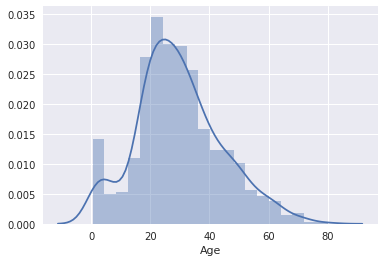

In [12]:
sns.distplot(train['Age'][~train['Age'].isnull()])

In [13]:
sns.distplot(train['LearnedAge'])

KeyError: 'LearnedAge'

In [35]:
transformer = Pipeline([
    ('union', FeatureUnion([
        ('age', Pipeline([
            ('select', ItemSelector('LearnedAge')),
            ('scaler', StandardScaler()),
        ])),
        ('family_size', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('scaler', StandardScaler()),
        ])),
        ('is_alone', Pipeline([
            ('select', ItemSelector('IsAlone')),
        ])),
        ('is_child', Pipeline([
            ('select', ItemSelector('IsChild')),
        ])),
        ('sibsp', Pipeline([
            ('select', ItemSelector('SibSp')),
            ('scaler', StandardScaler()),
        ])),
        ('parch', Pipeline([
            ('select', ItemSelector('Parch')),
            ('scaler', StandardScaler()),
        ])),
        ('Fare', Pipeline([
            ('select', ItemSelector('Fare')),
            ('scaler', StandardScaler()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Sex')),
            ('imputer', StringImputer()),
            ('encoder', StringLabelBinerizer()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('imputer', StringImputer()),
            ('encoder', StringLabelBinerizer()),
        ])),
    ])),
])
transformed_train = pd.DataFrame(transformer.fit_transform(train.drop(['Survived'], 1)))

NameError: name 'ItemSelector' is not defined

It looks like we will need to scale BetterAge and Fare.

In [109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 15 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           714 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Ticket        891 non-null object
Fare          891 non-null float64
Cabin         204 non-null object
Embarked      889 non-null object
LearnedAge    891 non-null float64
FamilySize    891 non-null int64
IsAlone       891 non-null int64
IsChild       891 non-null int64
dtypes: float64(3), int64(7), object(5)
memory usage: 151.4+ KB


# Visualizing correlations

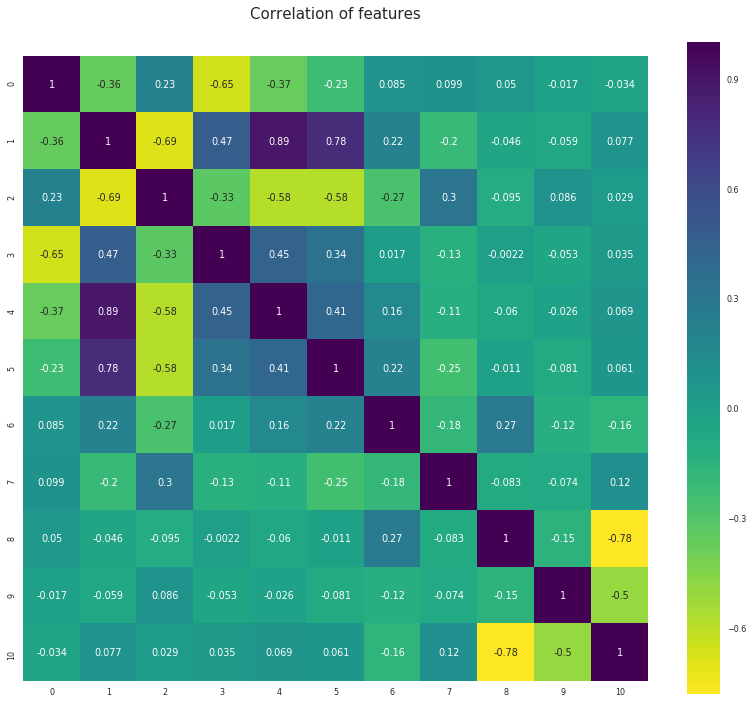

In [110]:
plt.figure(figsize=(14, 12))
plt.title('Correlation of features', y=1.05, size=15)
sns.set(font_scale=0.8)
sns.heatmap(transformed_train.astype(float).corr(), square=True, annot=True, cmap=plt.cm.viridis_r)

In [111]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

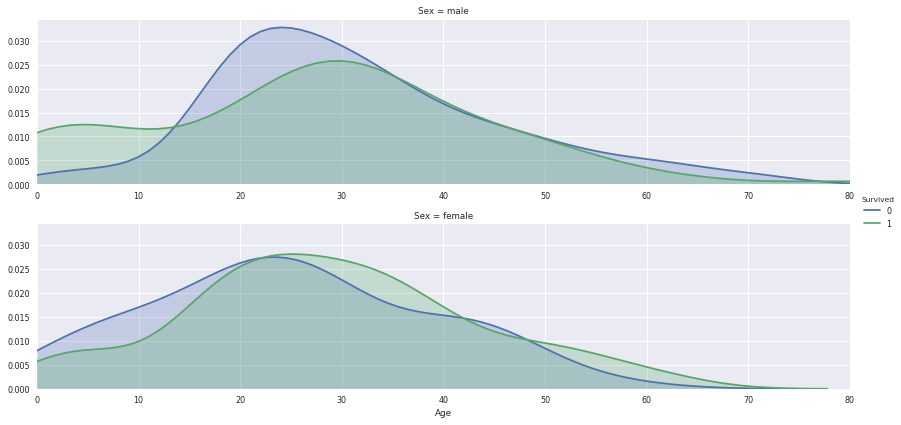

In [112]:
plot_distribution( train , var = 'Age' , target = 'Survived' , row = 'Sex' )

In [113]:


svc_model = SVC(random_state=88)
logistic_model = LogisticRegression(random_state=888)
random_model = RandomForestClassifier(random_state=88)

scores = cross_val_score(svc_model, transformer.fit_transform(train.drop(['Survived'], axis=1)), train['Survived'], cv=5)
print(scores)
print(scores.mean())
scores = cross_val_score(logistic_model, transformer.fit_transform(train.drop(['Survived'], axis=1)), train['Survived'], cv=5)
print(scores)
print(scores.mean())
scores = cross_val_score(random_model, transformer.fit_transform(train.drop(['Survived'], axis=1)), train['Survived'], cv=5)
print(scores)
print(scores.mean())

[ 0.82681564  0.82122905  0.80898876  0.81460674  0.85310734]
0.824949508598
[ 0.79329609  0.80446927  0.76966292  0.78651685  0.8079096 ]
0.792370948586
[ 0.80446927  0.78212291  0.8258427   0.75280899  0.80225989]
0.793500750234


# Predictions from the model

In [114]:
def save_predictions(model, test, file_name):
    predictions = model.predict(test)
    frame = pd.DataFrame({
        'PassengerId': pd.read_csv('data/titanic/test.csv').PassengerId,
        'Survived': predictions
    })
    frame = frame.set_index('PassengerId')
    frame.to_csv('~/data/' + file_name + '.csv')

In [115]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 14 columns):
Pclass        418 non-null int64
Name          418 non-null object
Sex           418 non-null object
Age           332 non-null float64
SibSp         418 non-null int64
Parch         418 non-null int64
Ticket        418 non-null object
Fare          417 non-null float64
Cabin         91 non-null object
Embarked      418 non-null object
LearnedAge    418 non-null float64
FamilySize    418 non-null int64
IsAlone       418 non-null int64
IsChild       418 non-null int64
dtypes: float64(3), int64(6), object(5)
memory usage: 69.0+ KB


In [121]:
transformer.fit_transform(test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [120]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'LearnedAge', 'FamilySize', 'IsAlone',
       'IsChild'],
      dtype='object')